In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from modeling.the_globals import gdp, popl
from modeling.t_series import T_Series, Full_fit, time_series

In [2]:
_df = pd.read_csv('USGDP_1790-2021.csv', header=1, thousands=',')
dates = np.array(_df['Year'])
for c in _df.columns:
    if 'Population' in c: data_pop = 1.E3*np.array(_df[c])
    if 'Real GDP' in c:   data_gdp = 1.E6*np.array(_df[c])

# Population Time Series
Create a T_Series instance from the data, check that the time series corresponds to a growth process.

In [3]:
info, data = popl, data_pop
hdr = f'US {info.desc}'
hdr += f': {len(data)} data points, from {info.t_unit} {dates[0]}--{dates[-1]}'
ts_pop = T_Series(info, data, dates=dates, hdr=hdr, verbose=2)

________________________________________________________________________

♦♦♦♦♦♦♦♦♦ US Population: 232 data points, from year 1790--2021 ♦♦♦♦♦♦♦♦♦
________________________________________________________________________

Population grew from 3.93 million in 1790 to 331.89 million in 2021
an increase by factor of 84.47
MK-Tests: Zmax = 22.68
Evidence for growth from data: z = 22.7, p-value = 0
Evidence for decline from growth rate: z = -16.8, p-value = 1.39E-63
Evidence for decline from growth-rate spline: z = -22.1, p-value = 3E-108


## The Trend
The dataset shows long-term growth, so proceed to determine the best-fitting trend. With the option verbose = 2 we will get full output, including step-by-step details of the search for the best fit.

In [4]:
ts_pop.hfit = ts_pop.get_trend(verbose=2)


Fitting done minimizing SUM(1 - model/data)**2

Modeling with exponential, [ru, q0]:
rss = 1.59E+01, fvu = 1.02E-01; popt: 1.92E-02, 7.05E-02
gu = 1.92%, qh = 7.05E-02

Modeling with logistic, [ru, qh, xh]:
rss = 1.37E+00, fvu = 8.75E-03; popt: 2.80E-02, 1.85E+00, 4.27E+00
gu = 2.80%, qh = 1.85E+00, xh = 4.27E+00

Modeling with single-term hindering, [ru, qh, xh]:
k = 1: rss = 2.23E-01, fvu = 1.42E-03; popt: 3.38E-02, 1.14E+00, 4.19E+00
k = 2: rss = 1.00E+00, fvu = 6.41E-03; popt: 2.77E-02, 1.64E+00, 4.00E+00
***rss minimum = 2.225E-01: k = 1
gu = 3.38%, qh = 1.14E+00, xh = 4.19E+00

****F-testing fits with exp (p = 2) and sth, k = 1 (p = 3):
Fcrit = 6.747 for alpha = 0.01
F = 1.61E+04, alpha = 1.11E-16; fit with sth, k = 1 is preferred

Adding term to k = 1: 
Modeling with multi-term hindering, [ru, qh, xh, a_list]:
k = [1, 2]: rss = 2.23E-01, fvu = 1.42E-03; popt: 3.38E-02, 1.14E+00, 4.19E+00, 5.46E+00, 4.09E-15
k = [1, 3]: rss = 2.23E-01, fvu = 1.42E-03; popt: 3.38E-02, 1.14E+00, 4

,fluc mean,bic,gu(/year),Qh,xh,th(year),yh
"sth, k = 1",9.59E-04,"-1,595.93",3.38%,9.62E+07,4.19,124.17,1914
"mth, k = [1, 2]",9.59E-04,"-1,590.48",3.38%,9.62E+07,4.19,124.17,1914
logist,5.91E-03,"-1,174.11",2.80%,1.57E+08,4.27,152.51,1942
exp,6.87E-02,-610.41,1.92%,,,,



logistic: K = 3.13E+08


## The Fluctuations
Determine the best-fitting ARMA model to the fluctuations around the trend line. This is done by searching for the (p,q) parameters pair that minimizes the BIC of fits with ARMA(p,q).

In [5]:
from modeling.arma import best_arma
ts_pop.arma = best_arma(ts_pop.hfit.dev, dates=ts_pop.dates, verbose=2)


(p, q)     BIC
(0, 1)   -1250.56
(1, 0)   -1966.17
(1, 1)   -2101.83
(0, 2)   -1531.40
(1, 2)   -2191.24
(2, 0)   -2280.73
(2, 1)   -2278.64
(2, 2)   -2282.97
(0, 3)   -1720.65
(1, 3)   -2137.00
(2, 3)   -2277.28
(3, 0)   -2277.49
(3, 1)   -2277.47
(3, 2)   -2255.57
(3, 3)   -2271.68

ARMA(2, 2) is the fit with minimum BIC = -2282.97
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.009      0.103      0.918      -0.017       0.019
ar.L1          1.8779      0.038     49.417      0.000       1.803       1.952
ar.L2         -0.8881      0.038    -23.617      0.000      -0.962      -0.814
ma.L1          0.1267      0.058      2.196      0.028       0.014       0.240
ma.L2         -0.2262      0.058     -3.927      0.000      -0.339      -0.113
sigma2      2.621e-06   1.72e-07     15.251      0.000    2.28e-06    2.96e-06


## Full Fit
Combine the best-fitting trend line and ARMA fit to the fluctuations to produce the overall best fit to the data:

\begin{equation}
\tt
    model = \frac{trend}{1 - arma}
\end{equation}

Error estimates are obtained by constructing two samples: one for the trend, with multivariate normal distribution centered on the hindering solution optimal parameters and using their covariance matrix, the other for the fluctuations. With the above equation we construct from the two the overall sample from which we determine the model standard error (ste) and 95\% confidence interval
(CI). Checking whether the sampling mean agrees with the fitted model is a test of sample size.


In [6]:
ts_pop.fit = Full_fit(ts_pop.time, ts_pop.hfit, ts_pop.arma, verbose=2)


*** CI(95) calculation for full fit:
sample_size = 100, err = 3.77E-04 < acc = 1.00E-02


## Summary Plot

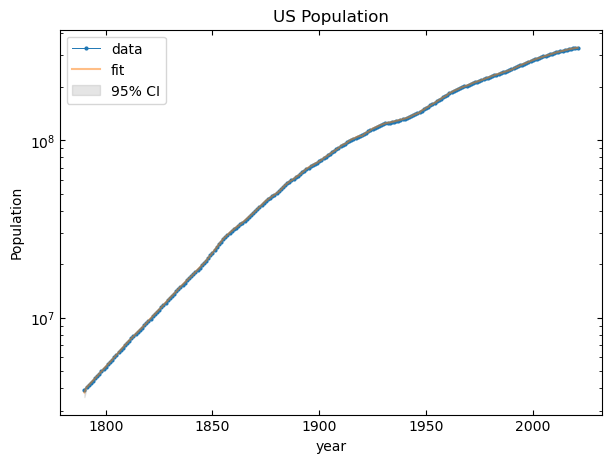

In [7]:
def summary_plot(ts):
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['xtick.top'] = True
    plt.rcParams['ytick.right'] = True
    
    Fig, fig = plt.subplots(figsize=(7,5))
    info = ts.info                # information about the time series variable
    x = ts.dates                  # the series dates  
    fit = ts.fit
    y_list = [ts.data, fit.model] # the series data and the overall fit
    labels = ['data', 'fit']
    styles = [dict(color='C0', marker='o', lw=0.7, ms=2),
              dict(color='C1', lw=1.5, alpha=0.5)
             ]

    # plot the data and the overall fit
    for y, label, style in zip(y_list, labels, styles):
        fig.semilogy(x, y, label=label, **style)
    # The fit's confidence interval 
    fig.fill_between(x, fit.ci[:,0], fit.ci[:,1],
            label=f'{fit.conf}% CI', color='grey', alpha=.2
            )   

    fig.set(
            xlabel=info.t_unit,
            ylabel=f'{info.desc}' + (info.unit == '$')*' ($)',
            title=f'US {info.desc}',
           )
    fig.legend(loc='upper left')
    plt.show()

summary_plot(ts_pop)

# GDP - All in One
Here we generate the best-fitting trend, ARMA and overall model in a single step with the function time_series(). The final fit and all its components are properties of the resulting object ts_gdp. 

With verbose = 1, the output contains only the essential results, skipping the intermediate steps. 

In [8]:
info, data = gdp, data_gdp
hdr = f'US {info.desc} ($ = 2012 USD)'
hdr += f': {len(data)} data points, from {info.t_unit} {dates[0]}--{dates[-1]}'
ts_gdp = time_series(info, data, verbose=1,
                     kw_args=dict(dates=dates, hdr=hdr),
                    )

________________________________________________________________________

♦♦♦♦♦ US GDP ($ = 2012 USD): 232 data points, from year 1790--2021 ♦♦♦♦♦
________________________________________________________________________

GDP grew from $4.57 billion in 1790 to $19.43 trillion in 2021
an increase by factor of 4253
Evidence for growth from data: z = 22.5, p-value = 0
Evidence for decline from growth rate: z = -3.51, p-value = 0.00022
Evidence for decline from growth-rate spline: z = -22.7, p-value = 3.92E-114

♦♦♦♦♦♦♦♦ Growth Trend ♦♦♦♦♦♦♦♦

Fitting done minimizing SUM(1 - model/data)**2

***** Best-fit model is single-term hindering, k = 1
gu = 3.83%±0.02%; Qh = 3.12E+13±3.43E+12; th = 250.96±2.68E+00, yh = 2040
gu(t - th) = [-9.61, -0.76], Q/Qh = [0.00015, 0.62]
Fluctuations = (data - fit)/data: mean = 1.71E-02, std = 1.29E-01
No evidence for trend from fluctuations: z = 1.47, p-value = 0.0356

♦♦♦♦♦♦♦♦♦♦♦♦ ARMA ♦♦♦♦♦♦♦♦♦♦♦♦

AR(2) is the fit with minimum BIC = -815.15
                 

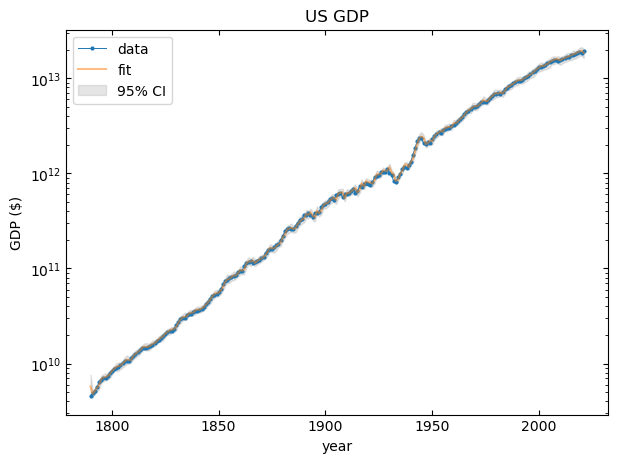

In [9]:
summary_plot(ts_gdp)